# Libaries and Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from collections import defaultdict


"""
    Math Plot Library Configs
"""

%matplotlib inline
mpl.style.use('seaborn')
mpl.rcParams["figure.facecolor"] ='#f6f5f5'

"""
    Pandas Configs
"""

# show all columns
pd.set_option('max_columns', None)

# show all rows
pd.set_option("max_rows", None)

# Whether to print out the full DataFrame repr for wide DataFrames across multiple lines, 
# max_columns is still respected, but the output will wrap-around across multiple “pages” 
# if it’s width exceeds display.width. [default: True] [currently: True]
pd.set_option('display.expand_frame_repr', False)


"""
    Seaborn Configs
"""
sns.set_palette("pastel")

# Notebook Setup
Load CSV into Panda Dataframe, and clean up data

In [2]:
raw = pd.read_csv('../adult_data.csv', index_col=False, skipinitialspace=True)

print('Raw Data Shape:',raw.shape)
print()
raw.info()
display(raw.head())

Raw Data Shape: (32561, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               32561 non-null  int64 
 1   work class        32561 non-null  object
 2   final weight      32561 non-null  int64 
 3   education         32561 non-null  object
 4   education number  32561 non-null  int64 
 5   marital status    32561 non-null  object
 6   occupation        32561 non-null  object
 7   relationship      32561 non-null  object
 8   race              32561 non-null  object
 9   sex               32561 non-null  object
 10  capital gain      32561 non-null  int64 
 11  capital loss      32561 non-null  int64 
 12  hours per week    32561 non-null  int64 
 13  native country    32561 non-null  object
 14  target            32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
raw_test = pd.read_csv('../adult_test.csv', index_col=False, skipinitialspace=True)

print('Test Raw Data Shape:', raw_test.shape)
print()
raw_test.info()
display(raw_test.head())

Test Raw Data Shape: (16281, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               16281 non-null  int64 
 1   work class        16281 non-null  object
 2   final weight      16281 non-null  int64 
 3   education         16281 non-null  object
 4   education number  16281 non-null  int64 
 5   marital status    16281 non-null  object
 6   occupation        16281 non-null  object
 7   relationship      16281 non-null  object
 8   race              16281 non-null  object
 9   sex               16281 non-null  object
 10  capital gain      16281 non-null  int64 
 11  capital loss      16281 non-null  int64 
 12  hours per week    16281 non-null  int64 
 13  native country    16281 non-null  object
 14  target            16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# Data Cleaning

In [4]:
df = raw.copy(deep=True)

TARGET_COLUMN = pd.Index(['target'])
CAT_COLUMNS = raw.select_dtypes(exclude=np.number).columns.drop(TARGET_COLUMN)
CON_COLUMNS = raw.select_dtypes(include=np.number).columns

print("Target Column:")
display(TARGET_COLUMN)
print()

Target Column:


Index(['target'], dtype='object')

## Categorical Columns
- It seems like some of the `Native Country` column has a bit of typos and misclassification. Let us fix that in advance.

In [5]:
df[df['hours per week'] == 0]

,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target


In [6]:
df[df['work class'] == '?']

,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,?,129305,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
149,43,?,174662,Some-college,10,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,<=50K
154,52,?,252903,HS-grad,9,Divorced,?,Not-in-family,White,Male,0,0,45,United-States,>50K
160,68,?,38317,1st-4th,2,Divorced,?,Not-in-family,White,Female,0,0,20,United-States,<=50K
187,53,?,135105,Bachelors,13,Divorced,?,Not-in-family,White,Female,0,0,50,United-States,<=50K


- It also seems like there are a couple of `?` columns in `work class` and `occupation`. 
- Since there are no people with 0 working hour, we can safely assume that they all had jobs, just that they didn't want to reveal their jobs.

In [7]:
print("Categorical Columns:")
display(CAT_COLUMNS)
print()


print('Catagorical Column\'s Values\n')
for col in df.select_dtypes(exclude=np.number).columns:
    unique = raw[col].unique()
    print('-'*7,f'columns {col}','-'*7)
    print(f'There are {len(unique)} Unique values')
    print(f'They are: {unique}\n')

Categorical Columns:


Index(['work class', 'education', 'marital status', 'occupation',
       'relationship', 'race', 'sex', 'native country'],
      dtype='object')


Catagorical Column's Values

------- columns work class -------
There are 9 Unique values
They are: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

------- columns education -------
There are 16 Unique values
They are: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

------- columns marital status -------
There are 7 Unique values
They are: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

------- columns occupation -------
There are 15 Unique values
They are: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

------- columns relationship -

In [8]:
# replace all '?' with the word 'Unknown'
# df.replace(to_replace=['?'], value='Unknown', inplace = True)

# fix all typos in countries
df['native country'].replace(to_replace=['South'], value='South Korea', inplace=True)
df['native country'].replace(to_replace=['Hong'], value='Hong Kong', inplace=True)

# merge all 'Outlying-US(Guam-USVI-etc)' terittories together
# https://www.aacrao.org/edge/country/u.s.-territories-and-minor-outlying-islands
df['native country'].replace(to_replace=['Puerto-Rico'], value='Outlying-US(Guam-USVI-etc)', inplace=True)

# Scotland is a part of UK
df['native country'].replace(to_replace=['Scotland'], value='United-Kingdom', inplace=True)

## Continious Columns
It seems like there is no `NaN` / negative values on the numeric values.

So, it is safe to assume that we don't have to manipulate the numeric columns. 

In [9]:
print("Continious Columns:")
display(CON_COLUMNS)
print()

print(f'Does any of continious columns contain NaN:\n{df[CON_COLUMNS].isnull().values.any()}\n')
print(f'Does any of continious columns contain negative value:\n{(df[CON_COLUMNS].values < 0).any()}')

Continious Columns:


Index(['age', 'final weight', 'education number', 'capital gain',
       'capital loss', 'hours per week'],
      dtype='object')


Does any of continious columns contain NaN:
False

Does any of continious columns contain negative value:
False


# Exploratory Data Analysis (EDA) using Data Visualization

Columns:
- age: the age of the responder
- workclass: the type of work fo the responder
- final weight: the number of units in the target population that the responding unit represents.
- education: education level (in words)
- education-num: the number of years of education in total
- marital-status: self-explanatory
- occupation: self-explanatory
- relationship: the responder's role in the family
- race: self-explanatory
- sex: self-explanatory
- capital-gain: income from investmenet (other than wage / salary)
- capital-loss: loss due to investment
- hours-per-week: self-explanatory
- native-country: self-explanatory
- target: the expected prediction outcome

In [10]:
# A bit difference is the idea behind. OrdinalEncoder is for converting features, 
# while LabelEncoder is for converting target variable.
# source: https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder

# USAGE
# numeric_df, d = label_encoder(df)
# reverse_label_encoder(numeric_df, d)
def label_encoder(df):
    d = defaultdict(LabelEncoder)
    return df.apply(lambda x: d[x.name].fit_transform(x)), d

def reverse_label_encoder(numeric_df, d):
    return numeric_df.apply(lambda x: d[x.name].inverse_transform(x))

# USAGE
# numeric_df, enc = ordinal_encoder(df, encode_cat_only=True)
# reverse_ordinal_encoder(numeric_df, enc, encode_cat_only=True)
def ordinal_encoder(df, encode_cat_only=True):
    enc = OrdinalEncoder()
    tmp = df.copy(deep=True)
    
    if encode_cat_only:
        tmp[CAT_COLUMNS] = enc.fit_transform(tmp[CAT_COLUMNS])
    else:
        all_cols = tmp.columns
        tmp[all_cols] = enc.fit_transform(tmp[all_cols])
    
    return tmp, enc

def reverse_ordinal_encoder(numeric_df, enc, encode_cat_only=True):
    if encode_cat_only:
        numeric_df[CAT_COLUMNS] = enc.inverse_transform(numeric_df[CAT_COLUMNS])
    else:
        all_cols = numeric_df.columns
        numeric_df[all_cols] = enc.inverse_transform(numeric_df[all_cols])
        
    return numeric_df

## Distribution Graph

### Continious Column Counts
**From the graphs below, we can draw the following conclusions:**

**Age**
- In general, the older they get, the more likely they are in the `>= 50k` group.
- The age of 37 - 47 seem to be where the most `>= 50k` folks lie.
- Both of the clusters decreased significantly as the age increases.

**Final Weight**
- Final weight is pretty much evenly distributed. Hence, making it a good choice to be included into our model.

**Education Number**
- In general, the higher the education, the more likely they are in the `>=50k` group.


**Capital Gain & Capital Loss**
- `Capital Gain & Capital Loss` are not evenly distributed. We might want to use the Relationship Graph to see if they are related.


**Hours per Week**
- Most of the `>=50k` folks put in around 40 hrs of work / week. So, working longer doesn't always translate to higher income.

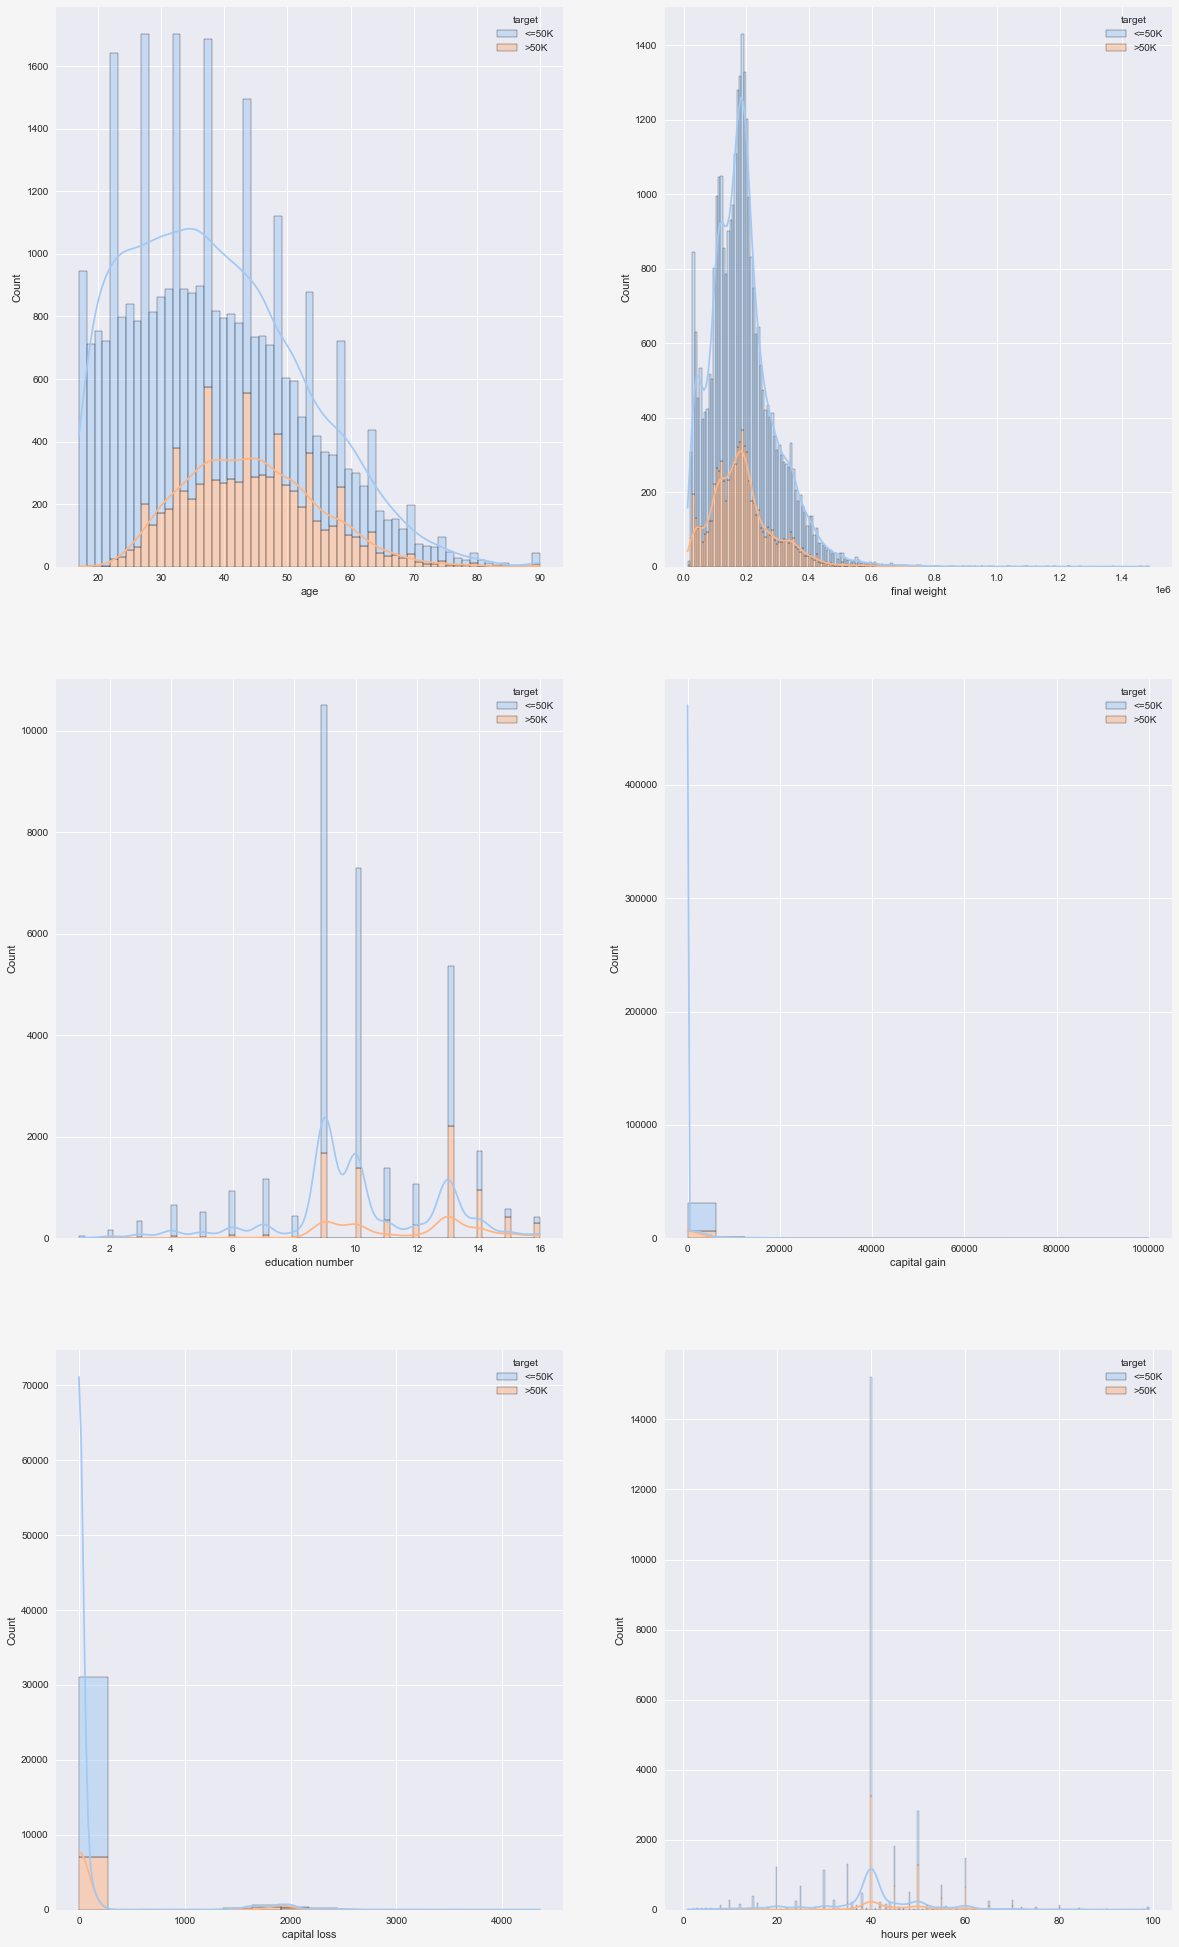

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(20, 35))
for col, subplot in zip(CON_COLUMNS, ax.flatten()):
    sns.histplot(data=df, x=col, hue="target", multiple="stack", ax=subplot, kde=True)

### Categorical Column Counts
**From the graphs below, we can draw the following conclusions:**

**Work Class**
- This doesn't seem to be a good feature to use as the responders' `work class` are mostly `private` sector.

**Education**
- This is potentially a good feature to use as the responders are evenly distributed among all of the groups. The higher the education, the higher the tendency of a responder being in the `>50k` group.

**Marital Status**
- This doesn't seem to be a good feature to use as the distribution of the `<=50k` is mostly concentrated on the `never married` group, whereas the `>50k` is mostly concentrated on the `married-civ-spouse` group.

**Occupation**
- This is potentially a good feature to use as the responders are evenly distributed among all of the groups.

**Relationship**
- The responders are not evenly distributed, making this a not so good feature to use.

**Race**
- Most of the responders are `white`, making this a very poor feature to use.

**Sex**
- There are more males in the `>50k` group, making this a decent feature to consider.

**Native Country**
- Most of the responders came from the `US`, making this a very poor feature to use.

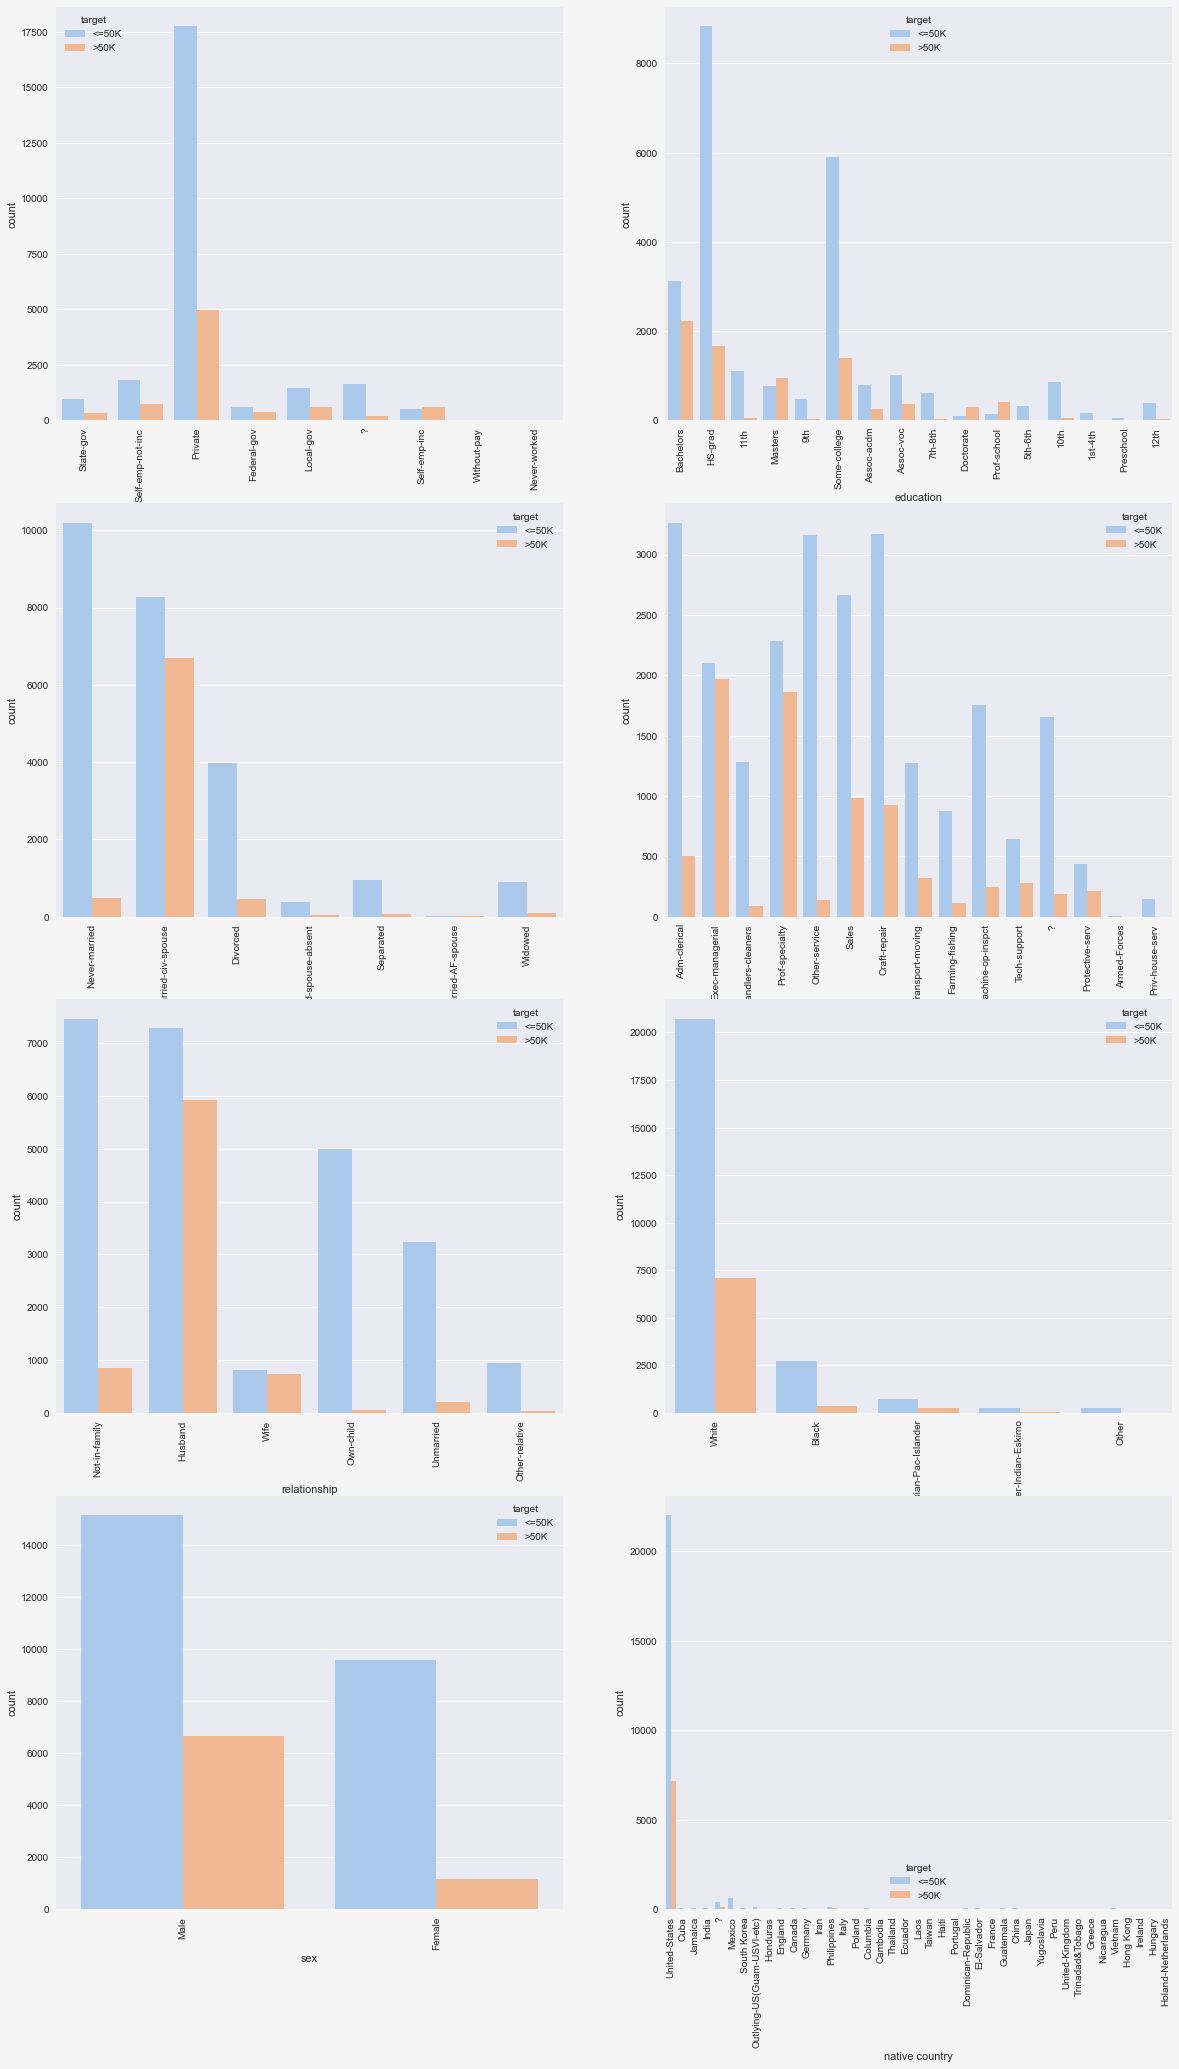

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(20, 35))
for col, subplot in zip(CAT_COLUMNS, ax.flatten()):
    sns.countplot(data=df, x=col, ax=subplot, hue="target")
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

## Relationship Graph

### Continuous Columns
From the heatmap below, we can conclude that:
- `capital gain` and `education number` are somehow co-related to `target`
- `work per hour` and `age` may be related to `target`

Other intersting findings:
- Educated folks tend to have longer `work per hour`
- Educated and older folks also have the tendency to have more `capital gain`

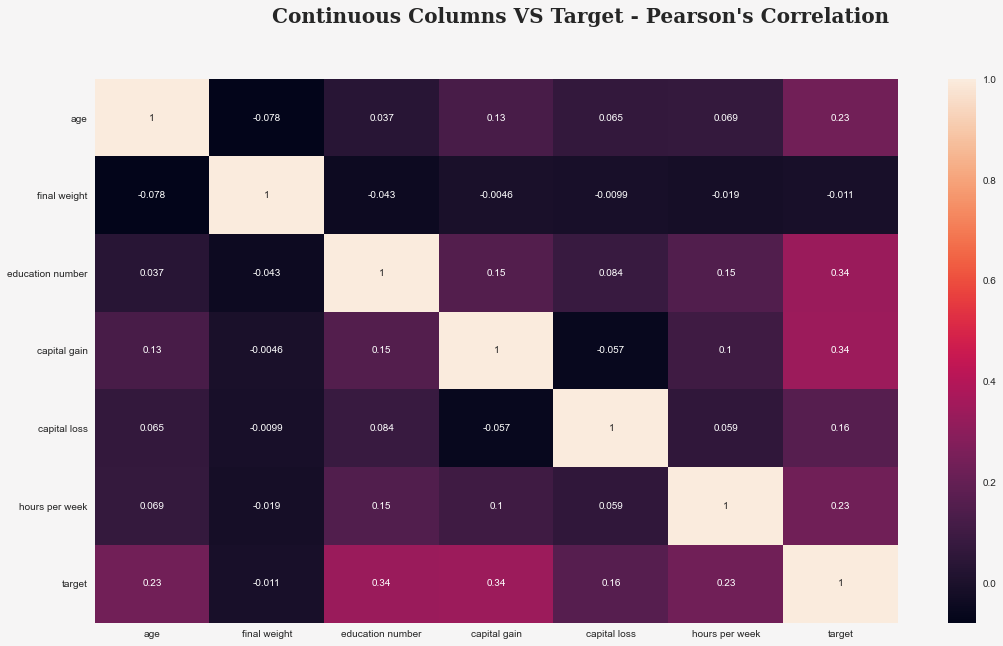

In [13]:
plt.figure(figsize=(18,10))

cat_cols, _ = label_encoder(df[CON_COLUMNS.append(TARGET_COLUMN)])
sns.heatmap(cat_cols.corr(),annot=True)

plt.suptitle('Continuous Columns VS Target - Pearson\'s Correlation',size=20, fontweight='bold', fontfamily='serif')
plt.show()

- Those in the `>50k` are generally more educated than their `<=50k` counterparts.

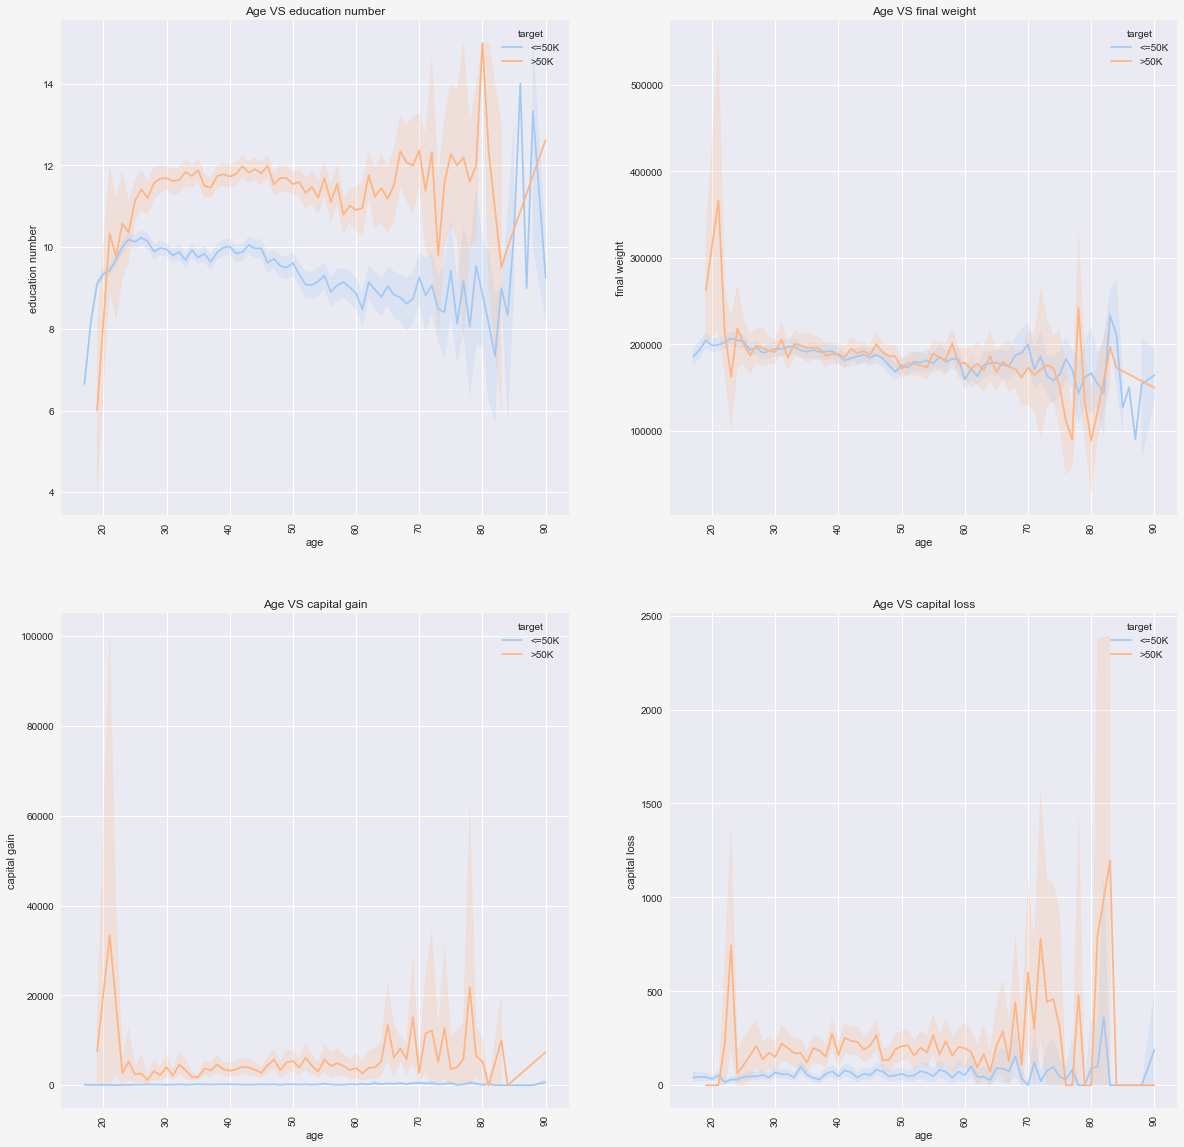

In [14]:
COLS = ['education number', 'final weight', 'capital gain', 'capital loss']

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for col, subplot in zip(COLS, ax.flatten()):
    subplot.title.set_text(f'Age VS {col}')
    sns.lineplot(data=df, x='age', y=col, hue='target', ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### Categorical Columns
From the heatmap below, we can conclude that:
- The responder's `sex` plays a big part in determining the `target`

Other intersting findings:
- `ocupation` and `work class` are somehow related
- `marital status` and `relationship` are tightly-knit
- `race` and `native country` are somehow related

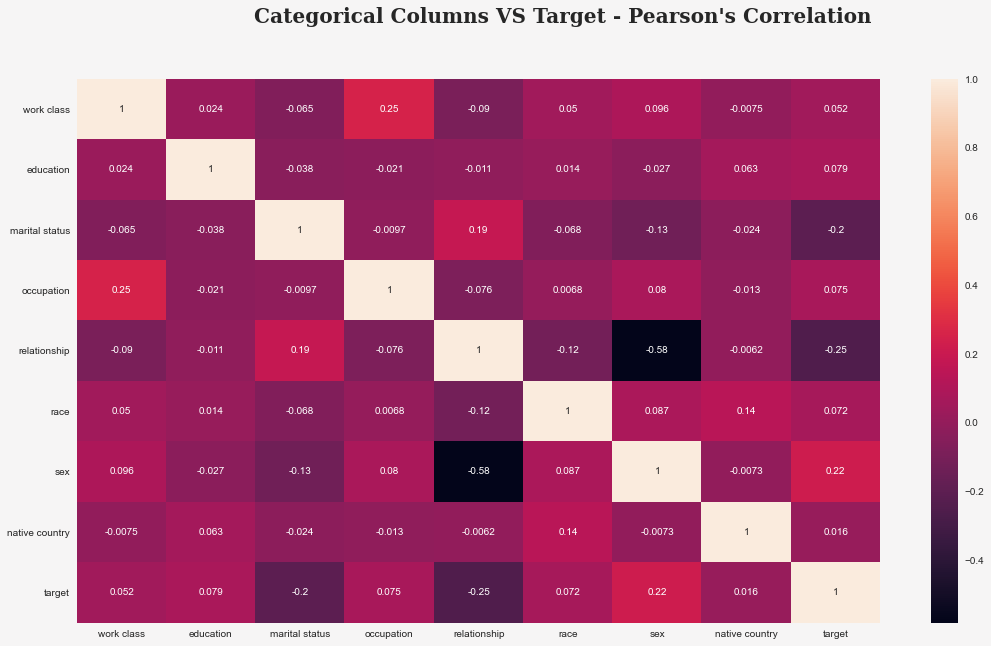

In [15]:
plt.figure(figsize=(18,10))

cat_cols, _ = label_encoder(df[CAT_COLUMNS.append(TARGET_COLUMN)])
sns.heatmap(cat_cols.corr(),annot=True)

plt.suptitle('Categorical Columns VS Target - Pearson\'s Correlation',size=20, fontweight='bold', fontfamily='serif')
plt.show()

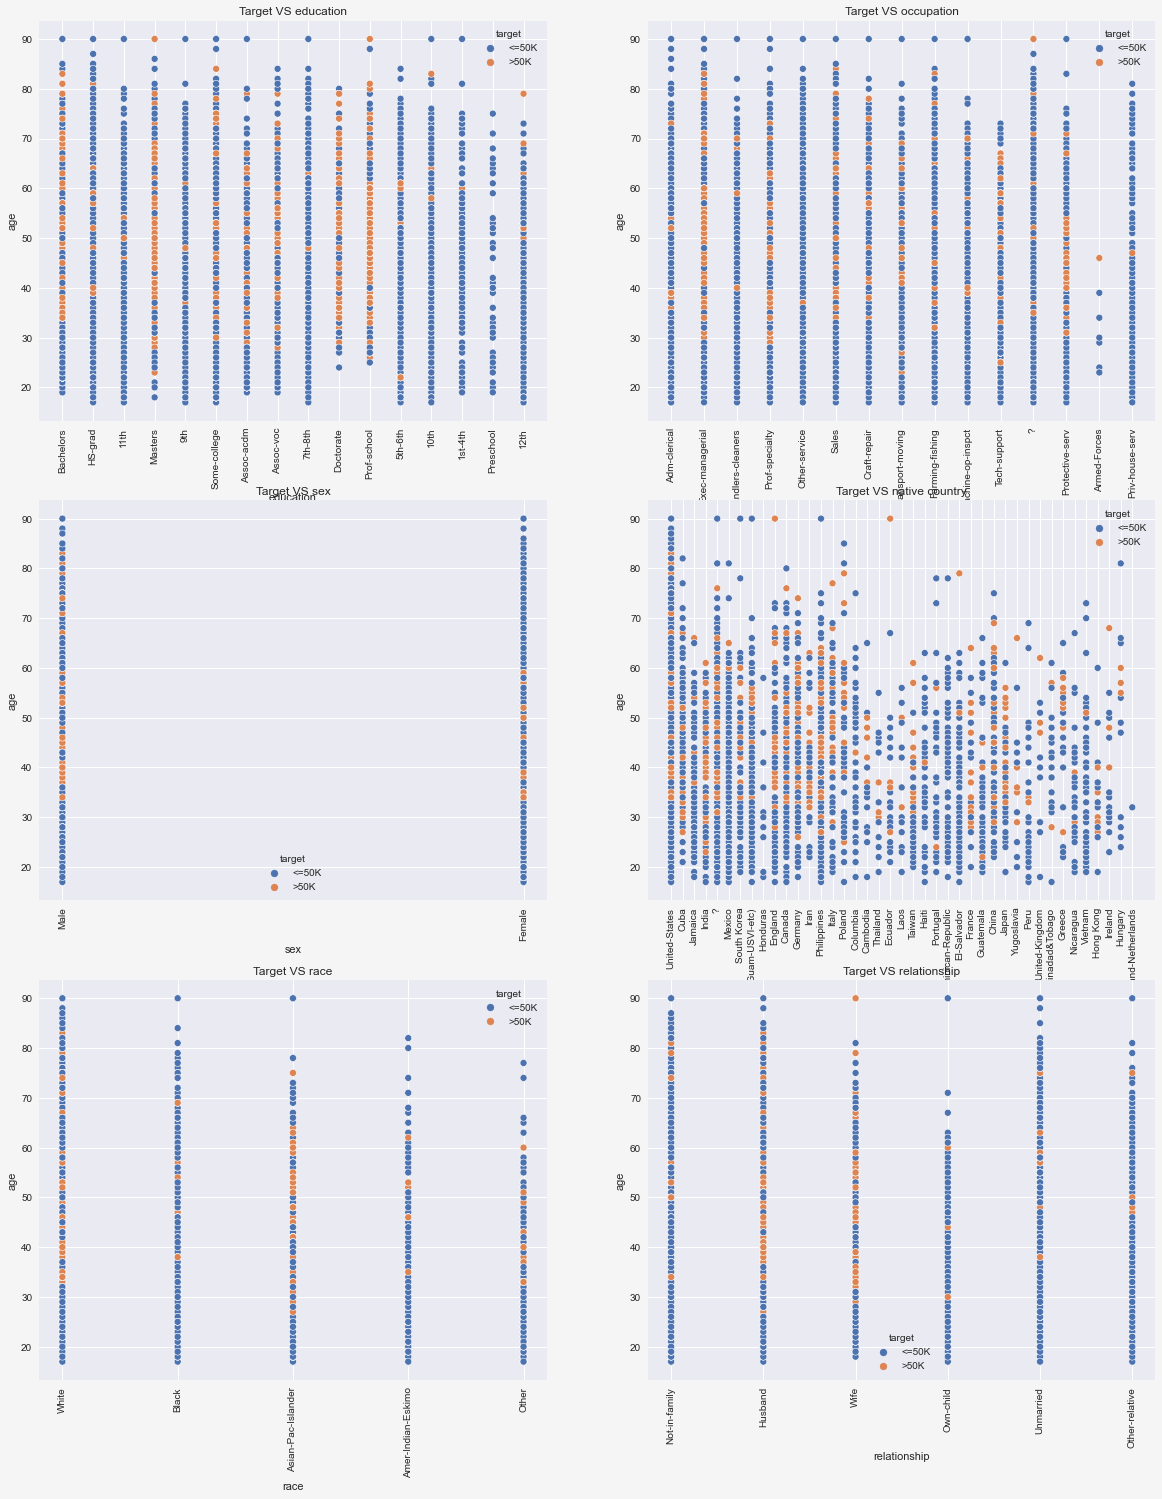

In [16]:
COLS = ['education', 'occupation', 'sex', 'native country', 'race', 'relationship']

fig, ax = plt.subplots(3, 2, figsize=(20, 25))
for col, subplot in zip(COLS, ax.flatten()):
    subplot.title.set_text(f'Target VS {col}')
    sns.scatterplot(data=df, x=col, y="age", hue="target", palette="deep", ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

## Data Modeling

### Data Pre-processing

In [17]:
"""
    Feature Selection and Data Splitting
"""

def clean_data(df, columns, value):
    data = df.copy()
    for column in columns:
        data = data.drop(data.loc[data[column] == value].index)
    return data

def get_target_and_features(df, feature_names, target_name, convert_to_numeric=False):
    temp = df.copy()
        
    if convert_to_numeric: 
        df, _ = ordinal_encoder(df, encode_cat_only=True)
    
    X = df[feature_names]
    y, _ = label_encoder(df[target_name])

    return X, y.values

def test_val_df_split(X, y, random_state, test_size):
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = random_state, test_size = test_size)
    
    return train_X, val_X, train_y, val_y

"""
    Data Modeling
"""

def fit_model(model, X, train_y):
    return model.fit(X, train_y)
    
def predict(model, val_X, val_y, print_individual_scores):
    score = model.score(val_X, val_y)
        
    if print_individual_scores:
        print(f'Epoch #{epoch}')
        print(f'Prediction Score: {score}')

    # make prediction
    return score, model.predict(val_X)

"""
    Model Evaluation
"""

def get_wrongly_predicted_df(predictions, val_X, val_y, print_individual_scores):    
    rounded_predictions = np.round(predictions, 0)
    
    # get the mask of wrong prediction
    predicted_correctly_mask = (rounded_predictions == val_y)
    not_predicted_correctly_mask = ~predicted_correctly_mask
    
    corect_result_arr = predicted_correctly_mask.tolist().count(True)
    accuracy_percentage = (corect_result_arr / val_y.size) * 100

    df_predictions = val_X.copy()
    df_predictions["correct_prediction"] = predicted_correctly_mask
    df_predictions["rounded_predictions"] = rounded_predictions
    df_predictions["expected_predictions"] = val_y
    
    if print_individual_scores:
        print(f'Prediction Accuracy: {round(accuracy_percentage, 2)}% \n\n')
        print(df_predictions.filter(['rounded_predictions', 'expected_predictions'], axis=1))
    
    return accuracy_percentage, df_predictions

def plot_predicted_wrongly_graph(df_predictions):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    axs = axs.flatten()
        
    sns.scatterplot(x="index", y="rounded_predictions", hue="correct_prediction", data=df_predictions.reset_index(), ax = axs[0])
    fig.delaxes(axs[1])    
    
#     sns.scatterplot(x="index", y="expected_predictions", data=df_predictions.reset_index(), ax = axs[1])

In [18]:
"""
    Variables
"""
CONVERT_TO_NUMERIC = True

TEST_SIZE = 0.25
TOTAL_EPOCH = 20

# TRAIN_FEATURES = ['age', 'sex', 'education number', 'capital gain']
TRAIN_FEATURES = ['age', 'sex', 'education number', 'capital gain', 'marital status']

PRINT_INDIVIDUAL_SCORES = False
SHOW_PREDICTED_CORRECTLY_GRAPH = False

IGNORE_UNKOWN_ROWS = True

"""
    Model
"""

# model = svm.SVC(degree=30)
# model = DecisionTreeRegressor(max_depth=400, max_leaf_nodes=400)
# model = LogisticRegression(max_iter=1000)
model = KNeighborsClassifier(n_neighbors=120)


"""
    MAIN
"""

# data pre-prcessing
X_adult, y_adult = get_target_and_features(df, TRAIN_FEATURES, TARGET_COLUMN, convert_to_numeric=CONVERT_TO_NUMERIC)
y_adult = np.ravel(y_adult)

total_score = 0
total_predicted_correctly_percentage = 0

# ignore all '?' rows
if IGNORE_UNKOWN_ROWS:
    df = clean_data(df, CAT_COLUMNS, '?')

for epoch in range(TOTAL_EPOCH):
    X_train, X_val, y_train, y_val = test_val_df_split(X_adult, y_adult, epoch, TEST_SIZE)

    # fit model
    adult_model = fit_model(model, X_train, y_train)

    # predict
    score, predictions = predict(adult_model, X_val, y_val, PRINT_INDIVIDUAL_SCORES)
    total_score += score

    # figure out what went wrong
    accuracy_percentage, df_predictions = get_wrongly_predicted_df(predictions, X_val, y_val, PRINT_INDIVIDUAL_SCORES)

    if SHOW_PREDICTED_CORRECTLY_GRAPH:
        plot_predicted_wrongly_graph(df_predictions)
        
print(f'Mean Score: {total_score / TOTAL_EPOCH}')

Mean Score: 0.8424517872497237


### Scoring our Model

In [19]:
# https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

# try to run it with more model validation algorithms
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

# accuracy
scoring = 'accuracy'
results = cross_val_score(adult_model, X_adult, y_adult, cv=kfold, scoring=scoring)
print("Accuracy: %.3f (%.3f)\n" % (results.mean(), results.std()))

# log loss
scoring = 'neg_log_loss'
results = cross_val_score(model, X_adult, y_adult, cv=kfold, scoring=scoring)
print("Logloss: %.3f (%.3f)\n" % (results.mean(), results.std()))

# area under ROC curve
scoring = 'roc_auc'
results = cross_val_score(model, X_adult, y_adult, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)\n" % (results.mean(), results.std()))


print("\n================================================\n")

X_train, X_val, y_train, y_val = test_val_df_split(X_adult, y_adult, 7, 0.33)
adult_model = fit_model(model, X_train, y_train)
predicted = adult_model.predict(X_val)

# confusion matrix
# https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79
matrix = confusion_matrix(y_val, predicted)
print(matrix)
print()

report = classification_report(y_val, predicted)
print(report)

Accuracy: 0.844 (0.005)

Logloss: -0.347 (0.016)

AUC: 0.895 (0.007)



[[7658  511]
 [1247 1330]]

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      8169
           1       0.72      0.52      0.60      2577

    accuracy                           0.84     10746
   macro avg       0.79      0.73      0.75     10746
weighted avg       0.83      0.84      0.83     10746



## Run Model on Test Dataset

In [20]:
X_adult, y_adult = get_target_and_features(df, TRAIN_FEATURES, TARGET_COLUMN, convert_to_numeric=CONVERT_TO_NUMERIC)
y_adult = np.ravel(y_adult)

# fit model
adult_model = fit_model(model, X_adult, y_adult)

df_test = raw_test.copy(deep=True)
if IGNORE_UNKOWN_ROWS:
    df_test = clean_data(df_test, CAT_COLUMNS, '?')

X_adult, y_adult = get_target_and_features(df_test, TRAIN_FEATURES, TARGET_COLUMN, convert_to_numeric=CONVERT_TO_NUMERIC)

# predict
score, predictions = predict(adult_model, X_adult, y_adult, PRINT_INDIVIDUAL_SCORES)

print(f'Score: {score}')

Score: 0.8413014608233732


In [21]:
# ALL_FEATURES = df.columns.drop(TARGET_COLUMN)
# X_adult, y_adult = get_target_and_features(df, ALL_FEATURES, TARGET_COLUMN, convert_to_numeric=CONVERT_TO_NUMERIC)

# X_train, X_val, y_train, y_val = test_val_df_split(X_adult, y_adult, 0, 0.3)
# reg= ExtraTreesRegressor()
# reg.fit(X_train, np.ravel(y_train))
# display(reg.feature_importances_)

# feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()